# **The best place to live in San Francisco for a family with children**

In [460]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup 
import requests 

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
!pip install geocoder
import geocoder

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

## Load zip codes and neighborhoods of San Francisco

In [461]:
url = "http://www.healthysf.org/bdi/outcomes/zipmap.htm"

data  = requests.get(url).text

soup = BeautifulSoup(data,"html5lib")

In [462]:
table = soup.find_all("table")
df = pd.read_html(str(table))
df = pd.DataFrame(df[4])

#Drop unnecessary columns and rows
df.columns = df.iloc[0]
df = df.iloc[1:-1, :-1]

#Rename columns
df.rename(columns={'Zip Code':'ZipCode'}, inplace=True)

#Reset index
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(21, 2)


,ZipCode,Neighborhood
0,94102,Hayes Valley/Tenderloin/North of Market
1,94103,South of Market
2,94107,Potrero Hill
3,94108,Chinatown
4,94109,Polk/Russian Hill (Nob Hill)


### Get coordinates for each neighborhood

In [463]:
# Function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francisco, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [464]:
coords = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]

In [465]:
len(coords)

21

In [466]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['NeighborhoodLatitude'] = df_coords['Latitude']
df['NeighborhoodLongitude'] = df_coords['Longitude']

In [467]:
df.head()

,ZipCode,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude
0,94102,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833
1,94103,South of Market,37.77757,-122.40435
2,94107,Potrero Hill,37.75660,-122.39914
3,94108,Chinatown,37.79539,-122.40812
4,94109,Polk/Russian Hill (Nob Hill),37.80203,-122.41963


### Create dataframe: Neighborhood

In [468]:
neighborhood_df = df.loc[:, ['Neighborhood','NeighborhoodLatitude', 'NeighborhoodLongitude']]
neighborhood_df.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833
1,South of Market,37.77757,-122.40435
2,Potrero Hill,37.75660,-122.39914
3,Chinatown,37.79539,-122.40812
4,Polk/Russian Hill (Nob Hill),37.80203,-122.41963


### Get coordinates of San francisco

In [469]:
address = 'San Francisco'

geolocator = Nominatim(user_agent="san_francisco_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San francisco are 37.7790262, -122.419906.


## Create a map of San Francisco with neighborhoods

In [470]:
sf_map = folium.Map(location = [latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_df['NeighborhoodLatitude'], neighborhood_df['NeighborhoodLongitude'], neighborhood_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(sf_map)  
    
sf_map

## Explore Neighborhoods in San francisco

### Define Foursquare Credentials and Version

In [471]:
CLIENT_ID = 'WMEIY0IYN2JKNSUAN4DAIK4ILBKQY2PEEFYSJCFG0GXNOZYI' 
CLIENT_SECRET = 'X3HO4BQIRAV0YUYGVCNL0B3KLNBUU3CKQ2HZSV3OXZ00CEKR' 
VERSION = '20180605' 
LIMIT = 500

In [472]:
def getNearbyVenues(names, latitudes, longitudes, radius=850):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'NeighborhoodLatitude', 
                  'NeighborhoodLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [473]:
#Get nearby venues for each neighborhood
venues_df = getNearbyVenues(names=neighborhood_df['Neighborhood'], latitudes=neighborhood_df['NeighborhoodLatitude'], longitudes=neighborhood_df['NeighborhoodLongitude']
                                  )
print(venues_df.shape)
venues_df.head()

(1558, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,The Center SF,37.774545,-122.430730,Spiritual Center
1,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Church of 8 Wheels,37.774733,-122.430862,Roller Rink
2,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Domo Sushi,37.775951,-122.426151,Sushi Restaurant
3,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Salt & Straw,37.776532,-122.426051,Ice Cream Shop
4,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Suppenküche,37.776324,-122.426382,German Restaurant


In [474]:
# Check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 266 uniques categories.


In [475]:
#Check what categories we have in san francisco
venues_df['VenueCategory'].unique()

array(['Spiritual Center', 'Roller Rink', 'Sushi Restaurant',
       'Ice Cream Shop', 'German Restaurant', 'Spa', 'French Restaurant',
       'Pizza Place', 'Liquor Store', 'Sandwich Place', 'Bubble Tea Shop',
       'Dive Bar', 'Souvlaki Shop', 'Yoga Studio', 'Boutique',
       'Record Shop', 'Coffee Shop', 'Optical Shop', 'Kids Store',
       'Beer Garden', 'Cocktail Bar', 'Park', 'Dessert Shop', 'Bakery',
       'Event Space', 'Accessories Store', 'Butcher', 'Bagel Shop',
       'Clothing Store', 'New American Restaurant', 'Bike Shop',
       'Italian Restaurant', 'Korean Restaurant', 'Wine Bar',
       'Historic Site', 'Gym / Fitness Center', 'Comic Shop',
       'Pedestrian Plaza', 'Food & Drink Shop', 'Juice Bar',
       'Scandinavian Restaurant', 'Dumpling Restaurant', 'Wings Joint',
       'Bar', 'Bike Rental / Bike Share', 'Camera Store',
       'Japanese Restaurant', 'Vietnamese Restaurant', 'Café',
       'Ramen Restaurant', 'Pet Store', 'BBQ Joint', 'Playground',
       'M

## Data processing

In [476]:
#Create a list of venues which are important for children
venues_food = ['Ice Cream Shop', 'Pizza Place', 'Sandwich Place', 'Dessert Shop', 'Chocolate Shop', 'Candy Store', 'Cafeteria']
venues_park = ['Garden', 'Park', 'National Park', 'Beach', 'Picnic Area']
venues_life = ['Kids Store', 'Toy / Game Store', 'Playground', 'Bike Rental / Bike Share', 'Pharmacy', 'Bus Station', 'Shopping Mall', 'Zoo Exhibit', 'Zoo']
venues_sport = ['Gym / Fitness Center', 'Gym', 'Gym Pool', 'Baseball Field', 'Pool', 'Sports Club']
venues_filtered = venues_food + venues_park + venues_life + venues_sport


In [477]:
#Keep only rows with VenueCategory in our filtered venues list
indexNames = venues_df[~venues_df.VenueCategory.isin(venues_filtered)].index
venues_df.drop(indexNames , inplace=True)
print(venues_df.shape)
venues_df.head()

(313, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
3,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Salt & Straw,37.776532,-122.426051,Ice Cream Shop
7,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Gioia Pizzeria,37.776328,-122.425859,Pizza Place
9,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,The Lunchpad,37.776490,-122.425896,Sandwich Place
17,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Smitten Ice Cream,37.776273,-122.424235,Ice Cream Shop
20,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Fiddlesticks,37.776644,-122.425341,Kids Store


In [478]:
#Check that we have only filtered categories
venues_df['VenueCategory'].unique()

array(['Ice Cream Shop', 'Pizza Place', 'Sandwich Place', 'Kids Store',
       'Park', 'Dessert Shop', 'Gym / Fitness Center',
       'Bike Rental / Bike Share', 'Playground', 'Chocolate Shop', 'Gym',
       'Toy / Game Store', 'Garden', 'Cafeteria', 'Bus Station',
       'National Park', 'Beach', 'Candy Store', 'Pharmacy', 'Sports Club',
       'Baseball Field', 'Shopping Mall', 'Zoo Exhibit', 'Picnic Area',
       'Pool'], dtype=object)

Additionally we'll search for schools, because previous search returned only 2 types of schools

In [479]:
def searchVenuesByCategory(names, latitudes, longitudes, search_query, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['Neighborhood', 
                  'NeighborhoodLatitude', 
                  'NeighborhoodLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [480]:
schools_df = searchVenuesByCategory(names=neighborhood_df['Neighborhood'],
                                   latitudes=neighborhood_df['NeighborhoodLatitude'],
                                   longitudes=neighborhood_df['NeighborhoodLongitude'],
                                   search_query='School'
                                  )
print(schools_df['VenueCategory'].unique())
print(schools_df.shape)
schools_df.head()

['School' 'Elementary School' 'Adult Education Center' 'Music School'
 'Middle School' 'Preschool' 'Recording Studio' 'Office' 'Language School'
 'Trade School' 'High School' 'College Academic Building' 'Hockey Field'
 'Daycare' 'College Classroom' 'Music Store'
 'General College & University' 'Trail' 'Church']
(90, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Craft Haven,37.774812,-122.429767,School
1,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,AltSchool Alamo Square,37.774845,-122.430143,School
2,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,CAIS Waller St. Campus,37.772071,-122.424444,School
3,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,SAT Marketplace,37.771707,-122.424741,School
4,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,John Muir Elementary School,37.773624,-122.428363,Elementary School


Filter returned categories, let's keep schools only

In [481]:
venues_school = ['School', 'Elementary School', 'Music School', 'Middle School', 'Preschool', 'Language School', 'High School']

In [482]:
#Keep only rows with VenueCategory in our filtered venues list
indexNames = schools_df[~schools_df.VenueCategory.isin(venues_school)].index
schools_df.drop(indexNames , inplace=True)
print(schools_df['VenueCategory'].unique())
print(schools_df.shape)
schools_df.head()

['School' 'Elementary School' 'Music School' 'Middle School' 'Preschool'
 'Language School' 'High School']
(74, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Craft Haven,37.774812,-122.429767,School
1,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,AltSchool Alamo Square,37.774845,-122.430143,School
2,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,CAIS Waller St. Campus,37.772071,-122.424444,School
3,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,SAT Marketplace,37.771707,-122.424741,School
4,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,John Muir Elementary School,37.773624,-122.428363,Elementary School


Append schools to the main dataframe

In [483]:
print('Venues df shape:', venues_df.shape)
print('Schools df shape:', schools_df.shape)

venues_df = venues_df.append(schools_df, ignore_index=True)
print('New Venues df shape:', venues_df.shape)
venues_df.head()

Venues df shape: (313, 7)
Schools df shape: (74, 7)
New Venues df shape: (387, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Salt & Straw,37.776532,-122.426051,Ice Cream Shop
1,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Gioia Pizzeria,37.776328,-122.425859,Pizza Place
2,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,The Lunchpad,37.776490,-122.425896,Sandwich Place
3,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Smitten Ice Cream,37.776273,-122.424235,Ice Cream Shop
4,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,Fiddlesticks,37.776644,-122.425341,Kids Store


### Check if any neighbourhood doesn't have any of required venues

In [484]:
print(len(neighborhood_df.Neighborhood.unique()))
print(len(venues_df.Neighborhood.unique()))
set(neighborhood_df.Neighborhood.unique()) - set(venues_df.Neighborhood.unique())

21
21


set()

### One-hot encoding

In [485]:
#One hot encoding
sf_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

print(sf_onehot.shape)
sf_onehot.head()

(387, 33)


,Neighborhood,Baseball Field,Beach,Bike Rental / Bike Share,Bus Station,Cafeteria,Candy Store,Chocolate Shop,Dessert Shop,Elementary School,Garden,Gym,Gym / Fitness Center,High School,Ice Cream Shop,Kids Store,Language School,Middle School,Music School,National Park,Park,Pharmacy,Picnic Area,Pizza Place,Playground,Pool,Preschool,Sandwich Place,School,Shopping Mall,Sports Club,Toy / Game Store,Zoo Exhibit
0,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Let's group rows by neighborhood and by taking the count of occurrence of each category

In [486]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
print(sf_grouped.shape)
sf_grouped.head()

(21, 33)


,Neighborhood,Baseball Field,Beach,Bike Rental / Bike Share,Bus Station,Cafeteria,Candy Store,Chocolate Shop,Dessert Shop,Elementary School,Garden,Gym,Gym / Fitness Center,High School,Ice Cream Shop,Kids Store,Language School,Middle School,Music School,National Park,Park,Pharmacy,Picnic Area,Pizza Place,Playground,Pool,Preschool,Sandwich Place,School,Shopping Mall,Sports Club,Toy / Game Store,Zoo Exhibit
0,Bayview-Hunters Point,0.0,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.100000,0.000000,0.1,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.100000,0.100000,0.0,0.000000,0.000000,0.1,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0
1,Castro/Noe Valley,0.0,0.0,0.000000,0.000000,0.0,0.0,0.052632,0.000000,0.000000,0.0,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.0,0.210526,0.052632,0.0,0.105263,0.157895,0.0,0.000000,0.052632,0.052632,0.052632,0.000000,0.052632,0.0
2,Chinatown,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.230769,0.0,0.038462,0.038462,0.000000,0.038462,0.000000,0.038462,0.000000,0.000000,0.0,0.153846,0.000000,0.0,0.192308,0.000000,0.0,0.076923,0.038462,0.153846,0.000000,0.000000,0.000000,0.0
3,Haight-Ashbury,0.0,0.0,0.000000,0.058824,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.117647,0.117647,0.000000,0.000000,0.000000,0.058824,0.0,0.235294,0.000000,0.0,0.176471,0.058824,0.0,0.000000,0.000000,0.058824,0.000000,0.058824,0.058824,0.0
4,Hayes Valley/Tenderloin/North of Market,0.0,0.0,0.038462,0.000000,0.0,0.0,0.038462,0.076923,0.038462,0.0,0.038462,0.076923,0.000000,0.076923,0.038462,0.000000,0.000000,0.076923,0.0,0.153846,0.000000,0.0,0.115385,0.038462,0.0,0.000000,0.038462,0.153846,0.000000,0.000000,0.000000,0.0


### Find the most common 10 venues for each neighborhood

In [487]:
num_top_venues = 10

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview-Hunters Point----
            venue  freq
0     Bus Station   0.2
1          School   0.2
2          Garden   0.1
3    Dessert Shop   0.1
4        Pharmacy   0.1
5            Pool   0.1
6             Gym   0.1
7            Park   0.1
8  Sandwich Place   0.0
9   National Park   0.0


----Castro/Noe Valley----
              venue  freq
0              Park  0.21
1               Gym  0.16
2        Playground  0.16
3       Pizza Place  0.11
4     Middle School  0.05
5  Toy / Game Store  0.05
6     Shopping Mall  0.05
7            School  0.05
8    Chocolate Shop  0.05
9    Sandwich Place  0.05


----Chinatown----
                  venue  freq
0     Elementary School  0.23
1           Pizza Place  0.19
2                School  0.15
3                  Park  0.15
4             Preschool  0.08
5        Ice Cream Shop  0.04
6       Language School  0.04
7        Sandwich Place  0.04
8                   Gym  0.04
9  Gym / Fitness Center  0.04


----Haight-Ashbury----
              ven

In [488]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [489]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,School,Bus Station,Pharmacy,Gym,Garden,Pool,Park,Dessert Shop,Zoo Exhibit,Gym / Fitness Center
1,Castro/Noe Valley,Park,Playground,Gym,Pizza Place,Chocolate Shop,Shopping Mall,School,Sandwich Place,Toy / Game Store,Pharmacy
2,Chinatown,Elementary School,Pizza Place,Park,School,Preschool,Gym / Fitness Center,Gym,Language School,Sandwich Place,Ice Cream Shop
3,Haight-Ashbury,Park,Pizza Place,High School,Ice Cream Shop,Sports Club,School,Bus Station,Toy / Game Store,Playground,Music School
4,Hayes Valley/Tenderloin/North of Market,School,Park,Pizza Place,Ice Cream Shop,Gym / Fitness Center,Dessert Shop,Music School,Gym,Elementary School,Bike Rental / Bike Share
5,Ingelside-Excelsior/Crocker-Amazon,Baseball Field,Pizza Place,Playground,Bus Station,Pharmacy,Bike Rental / Bike Share,Cafeteria,Candy Store,Chocolate Shop,Ice Cream Shop
6,Inner Mission/Bernal Heights,Playground,Pizza Place,Gym,Park,Gym / Fitness Center,Elementary School,Ice Cream Shop,Garden,Dessert Shop,Zoo Exhibit
7,Inner Richmond,Elementary School,Baseball Field,Playground,Toy / Game Store,Dessert Shop,Park,Pizza Place,Preschool,School,Ice Cream Shop
8,Lake Merced,Park,Playground,Gym,Preschool,Chocolate Shop,Gym / Fitness Center,Garden,Elementary School,Dessert Shop,Zoo Exhibit
9,Marina,Gym / Fitness Center,Sandwich Place,Park,Pizza Place,Gym,Ice Cream Shop,School,Playground,Middle School,Baseball Field


## Clustering

In [490]:
sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

### Find the best k - elbow method

In [491]:
nK = 15
kRange = range(1, nK + 1)
distortions = []

for k in kRange:
    model = KMeans(n_clusters=k)
    model.fit(sf_grouped_clustering)
    distortions.append(model.inertia_)

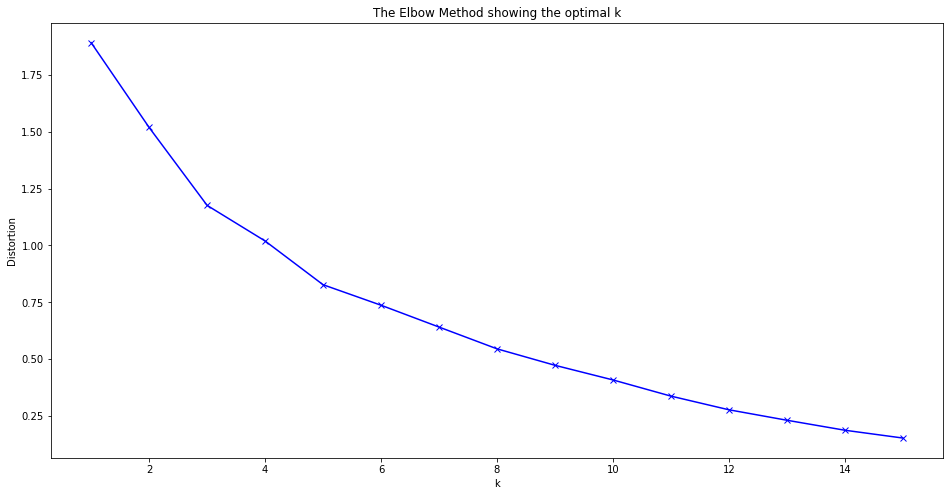

In [492]:
plt.figure(figsize=(16,8))
plt.plot(kRange, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Distortion is low, anyway we can the number 3 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 3.

### Run K-Means using 3 clusters

In [493]:
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1],
      dtype=int32)

### Add cluster labels to dataframe

In [494]:
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

sf_merged = neighborhood_df

# merge to add latitude/longitude for each neighbourhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,1,School,Park,Pizza Place,Ice Cream Shop,Gym / Fitness Center,Dessert Shop,Music School,Gym,Elementary School,Bike Rental / Bike Share
1,South of Market,37.77757,-122.40435,1,School,Pizza Place,Gym,Gym / Fitness Center,Sandwich Place,Garden,Elementary School,Preschool,Toy / Game Store,Playground
2,Potrero Hill,37.75660,-122.39914,1,Park,Pizza Place,Sandwich Place,Bus Station,Garden,Playground,Dessert Shop,Gym / Fitness Center,Gym,Cafeteria
3,Chinatown,37.79539,-122.40812,1,Elementary School,Pizza Place,Park,School,Preschool,Gym / Fitness Center,Gym,Language School,Sandwich Place,Ice Cream Shop
4,Polk/Russian Hill (Nob Hill),37.80203,-122.41963,1,Park,Ice Cream Shop,Chocolate Shop,Pizza Place,Gym / Fitness Center,Bike Rental / Bike Share,Playground,National Park,High School,Garden


## Visualize clusters on map

In [495]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['NeighborhoodLatitude'], sf_merged['NeighborhoodLongitude'], sf_merged['Neighborhood'], sf_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Check clusters

In [496]:
sf_grouped.insert(0, 'ClusterLabels', kmeans.labels_)

### Cluster 1

In [497]:
cluster_1_df = sf_merged.loc[sf_merged['ClusterLabels'] == 0, :]

print('Neighborhoods in cluster:', cluster_1_df.shape[0])
cluster_1_df.head()

Neighborhoods in cluster: 3


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Parkside/Forest Hill,37.748170,-122.464110,0,Playground,Park,Sandwich Place,Chocolate Shop,Gym / Fitness Center,Gym,Garden,Elementary School,Dessert Shop,Zoo Exhibit
17,Twin Peaks-Glen Park,37.754250,-122.446770,0,Park,Playground,Pizza Place,Bus Station,Garden,Gym / Fitness Center,Gym,Elementary School,Dessert Shop,Zoo Exhibit
18,Lake Merced,37.711259,-122.484863,0,Park,Playground,Gym,Preschool,Chocolate Shop,Gym / Fitness Center,Garden,Elementary School,Dessert Shop,Zoo Exhibit


In [498]:
mean_df_cl1 = sf_grouped.loc[sf_grouped['ClusterLabels'] == 0, :].mean().sort_values(ascending=False).to_frame().rename(columns={0:'Mean'})
mean_df_cl1[mean_df_cl1['Mean'] > 0.001]

,Mean
Park,0.377778
Playground,0.333333
Gym,0.066667
Preschool,0.066667
Sandwich Place,0.055556
Pizza Place,0.033333
Garden,0.033333
Bus Station,0.033333


### Cluster 2

In [499]:
cluster_2_df = sf_merged.loc[sf_merged['ClusterLabels'] == 1, :]

print('Neighborhoods in cluster:', cluster_2_df.shape[0])
cluster_2_df.head()

Neighborhoods in cluster: 17


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hayes Valley/Tenderloin/North of Market,37.77428,-122.42833,1,School,Park,Pizza Place,Ice Cream Shop,Gym / Fitness Center,Dessert Shop,Music School,Gym,Elementary School,Bike Rental / Bike Share
1,South of Market,37.77757,-122.40435,1,School,Pizza Place,Gym,Gym / Fitness Center,Sandwich Place,Garden,Elementary School,Preschool,Toy / Game Store,Playground
2,Potrero Hill,37.75660,-122.39914,1,Park,Pizza Place,Sandwich Place,Bus Station,Garden,Playground,Dessert Shop,Gym / Fitness Center,Gym,Cafeteria
3,Chinatown,37.79539,-122.40812,1,Elementary School,Pizza Place,Park,School,Preschool,Gym / Fitness Center,Gym,Language School,Sandwich Place,Ice Cream Shop
4,Polk/Russian Hill (Nob Hill),37.80203,-122.41963,1,Park,Ice Cream Shop,Chocolate Shop,Pizza Place,Gym / Fitness Center,Bike Rental / Bike Share,Playground,National Park,High School,Garden


In [500]:
mean_df_cl2 = sf_grouped.loc[sf_grouped['ClusterLabels'] == 1, :].mean().sort_values(ascending=False).to_frame().rename(columns={0:'Mean'})
mean_df_cl2.drop([mean_df_cl2.index[0]], inplace=True)
mean_df_cl2[mean_df_cl2['Mean'] > 0.001]

,Mean
Park,0.151138
Pizza Place,0.129225
Playground,0.088598
School,0.077828
Elementary School,0.061717
Ice Cream Shop,0.050171
Sandwich Place,0.049374
Gym,0.046906
Gym / Fitness Center,0.044445
Bus Station,0.041243


### Cluster 3

In [501]:
cluster_3_df = sf_merged.loc[sf_merged['ClusterLabels'] == 2, :]

print('Neighborhoods in cluster:', cluster_3_df.shape[0])
cluster_3_df.head()

Neighborhoods in cluster: 1


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Sunset,37.729626,-122.493405,2,Zoo Exhibit,Bus Station,Gym,Park,Picnic Area,Pizza Place,Sandwich Place,Shopping Mall,Cafeteria,Candy Store


In [502]:
#sf_grouped.loc[sf_grouped['ClusterLabels'] == 2, :].mean().sort_values(ascending=False)[:20]
mean_df_cl3 = sf_grouped.loc[sf_grouped['ClusterLabels'] == 2, :].mean().sort_values(ascending=False).to_frame().rename(columns={0:'Mean'})
mean_df_cl3.drop([mean_df_cl3.index[0]], inplace=True)
mean_df_cl3[mean_df_cl3['Mean'] > 0.001]

,Mean
Zoo Exhibit,0.5625
Gym,0.0625
Sandwich Place,0.0625
Shopping Mall,0.0625
Bus Station,0.0625
Pizza Place,0.0625
Picnic Area,0.0625
Park,0.0625


## Observations

The results from the k-means clustering show that we can categorize the neighbourhoods into 3 clusters based on the specific details of each cluster. 

**Cluster 1: “Welcome with Small children”**. This cluster is better for living with small kids. There is just preschool there, parks, playgrounds. 
This is a quite small cluster, 3 neighborhoods.


**Cluster 2: “Welcome with All children”**. This cluster can be used for living with children of any ages. There are many types of schools there, parks, kids stores, ice cream and pizza cafes and so on. A lot of different venues are located here. 
This is a big cluster, 17 neighborhoods.

**Cluster 3: “Welcome for a walk with children”**. There are no schools, kids stores and other places which are needed for a life with children. But there is a Zoo, parks and green area. It is nice for a walk! 
This is the smallest cluster, 1 neighborhood.
